In [27]:
import numpy as np
import tensorflow as tf 

In [46]:
cpus = tf.config.experimental.list_physical_devices('CPU')
try:
    tf.config.experimental.set_visible_devices(cpus[0], 'CPU')
    for device in visible_devices:
        assert device.device_type != 'CPU'
except RuntimeError as e:
    print(e)
    
visible_devices = tf.config.get_visible_devices()
print(visible_devices)

Visible devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [47]:
import psutil
psutil.cpu_percent()
dict(psutil.virtual_memory()._asdict())

{'total': 66978185216,
 'available': 24170082304,
 'percent': 63.9,
 'used': 42244182016,
 'free': 22862815232,
 'active': 38541774848,
 'inactive': 1809629184,
 'buffers': 1044480,
 'cached': 1870143488,
 'shared': 55185408,
 'slab': 791875584}

### **Positional Encoding**  

Transformer는 입력 시퀀스를 병렬적으로 처리하기 때문에, 입력 데이터는 위치정보를 포함하고 있어야 한다.  
Positional Encoding은 각 입베딩 벡터에 위치 정보를 더하는 과정이다.  

In [77]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, N, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(N, d_model)
    
    def get_positional_encoding(self, N, d_model):
        
        def get_pos_matrix(pos, i, d_model):
            pos_matrix = pos / tf.math.pow(10000, i / tf.cast(d_model, tf.float32))
            pos_matrix = pos_matrix.numpy()

            pos_matrix[:,0::2] = tf.math.sin(pos_matrix[:,0::2])
            pos_matrix[:,1::2] = tf.math.cos(pos_matrix[:,1::2])

            return pos_matrix

        pos_encoding = get_pos_matrix(pos=tf.range(N, dtype=tf.float32)[:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis,:], d_model=d_model)
   
        print("Positional Encoding", pos_encoding.shape)
        return tf.cast(pos_encoding[:,:], tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[tf.newaxis, :inputs.shape[1], :]

아래는 50개의 임베딩 벡터, 각 임베딩 벡터의 차원이 128일 때의 포지셔널 인코딩 행렬을 시각화한 것이다.

Positional Encoding (50, 128)


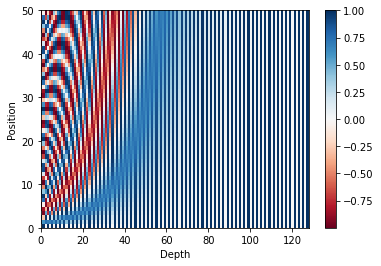

In [49]:
import matplotlib.pyplot as plt

pos_encoder = PositionalEncoding(50, 128)

plt.pcolormesh(pos_encoder.pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### **Padding Mask 생성**  
softmax 함수에 잘못된 값이 들어가는 경우에, 이 값을 연산에서 제외하기 위해 Padding Mask 단계를 거친다.  
mask에 -1e9 값을 곱해 Attention Score 행렬에 더한다.  

> 잘못된 값이란, 입력된 문장 행렬에서 <*PAD*>를 의미한다.  
> <*PAD*> 값을 의미하는 0을 찾아 마스킹한다.

In [50]:
def create_padding_mask(multiple_qk):
    mask = tf.cast(tf.math.equal(multiple_qk,0), tf.float32)
    return mask * -1e9

In [51]:
temp_k = tf.constant([[[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]]], dtype=tf.float32) 
tmp = tf.constant(np.arange(4*3*2).reshape((4,3,2)), dtype=tf.float32) 
create_padding_mask(tmp)

<tf.Tensor: shape=(4, 3, 2), dtype=float32, numpy=
array([[[-1.e+09, -0.e+00],
        [-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00]],

       [[-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00]],

       [[-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00]],

       [[-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00],
        [-0.e+00, -0.e+00]]], dtype=float32)>

### **Scaled Dot-product Attention**  
Dot-product Attention과 유사하나, k 벡터의 차원 값인 d_k의 루트 값을 나눠 scaling하는 과정이 추가되었다.

```
Attention(Q, K, V) = softmax(Q*K^T)*V               # Dot-product Attention
Attention(Q, K, V) = softmax((Q*K^T)/sqrt(d_k))*V   # Scaled Dot-product Attention
```

Encoder Self Attention  

```
Q size (batch_size, enc_seq, d_model)  
K size (batch_size, enc_seq, d_model)  
V size (batch_size, enc_seq, d_model)  
```

Decoder Self Attention  
```
Q size (batch_size, dec_seq, d_model)  
K size (batch_size, dec_seq, d_model)  
V size (batch_size, dec_seq, d_model)  
```

Decoder Attention  
```
Q size (batch_size, enc_seq, d_model)  
K size (batch_size, dec_seq, d_model)  
V size (batch_size, dec_seq, d_model)  
```

In [52]:
def scaled_dot_product_attention(query, key, value, mask_type):

    # Attention Score : Q * K^T
    attention_score_matrix = tf.matmul(query, key, transpose_b=True)
    
    # Scaling : Divide by sqrt(d_k)
    d_k = tf.cast(key.shape[-1], tf.float32)
    scaled_matrix = attention_score_matrix / tf.math.sqrt(d_k)

    # Padding Mask or Look-Ahead Mask
    if mask_type is 'padding':
        scaled_matrix += create_padding_mask(scaled_matrix)
    elif mask_type is 'look_ahead':
        scaled_matrix += create_look_ahead_mask(scaled_matrix)

    # Softmax fuction
    attention_weights = tf.nn.softmax(scaled_matrix, axis=-1) 

    # Weighted Sum : multiply V matrix
    attention_value = tf.matmul(attention_weights, value)

    return attention_value, attention_weights

아래는 `temp_k`, `temp_v`, `temp_q`가 입력으로 주어졌을 때 Attention Value와 Attention Distribution 을 구한 결과이다.

In [53]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  

In [54]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, 'padding')
print("Attention Distribution : {}".format(temp_attn)) 
print("Attention Value : {}".format(temp_out))

Attention Distribution : [[0. 1. 0. 0.]]
Attention Value : [[10.  0.]]


### **Muti-Head Attention**  
한번의 Attention을 수행하는 것보다, 여러번의 Attention을 병렬적으로 수행하는 것이 효율적이다.  
각 Attention을 수행한 결과로부터 각기 다른 관점의 정보를 수집할 수 있다.  

입력된 `query`, `key`, `value` 행렬 값이 각각 `(1, 1, 16)`, `(1, 4, 16)`, `(1, 4, 16)`이고, `d_model`이 16, `num_heads`가 4이라고 가정하자.  
이를 `num_heads`로 분할하여 각각 Attention을 적용하기 위해 입력된 행렬을 다음과 같이 분할한다.

```
(batch_size, num_heads, 입력 시퀀스 개수, d_model / num_heads)
```  
```
query.shape   # (1, 4, 1, 4)
key.shape     # (1, 4, 4, 4)
value.shape   # (1, 4, 4, 4)
```
 
**batch size**  
위 예제에서 batch_size는 1이다.
batch size는 모델 훈련에서의 1 batch 당 사용되는 token의 수를 의미한다.

위 query, key, value Tensor에 scaled dot-product attention을 적용하면  
`q vector=(1, 4)`, `k vector=(4, 4)`, `v vector= (4, 4)`에 대해 4번의 Attention을 각각 적용한 것과 동일하다.

이 후에 `num_heads`로 분할되어 있던 행렬을 이어 `(batch_size, 입력 시퀀스 개수, d_model)`로 변환한다. `

In [55]:
def printShape(Q, K, V, status):
    print("[{status}] Q shape : {q}, K shape : {k}, V shape : {v}\n".format(status=status, q=Q.shape, k=K.shape, v=V.shape))

In [56]:
class MultiHeadAttention:
    def __init__(self, num_heads, d_model):
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0, "depth가 정수 형식이 아닙니다."
        self.depth = self.d_model // self.num_heads

        # Dense 층의 출력 차원은 d_model
        self.WQ = tf.keras.layers.Dense(units=self.d_model)
        self.WK = tf.keras.layers.Dense(units=self.d_model)
        self.WV = tf.keras.layers.Dense(units=self.d_model)
        self.WO = tf.keras.layers.Dense(units=self.d_model)

    
    def get_attention(self, query, key, value, mask_type=None):

        printShape(query, key, value, "Input")
        
        def split_sequences(batch_size, num_heads, d_model, query, key, value):
            Q_list = tf.reshape(query, (batch_size, -1, num_heads, d_model // num_heads))
            K_list = tf.reshape(key, (batch_size, -1, num_heads, d_model // num_heads))
            V_list = tf.reshape(value, (batch_size, -1, num_heads, d_model // num_heads))

            return tf.transpose(Q_list, perm=[0, 2, 1, 3]), tf.transpose(K_list, perm=[0, 2, 1, 3]), tf.transpose(V_list, perm=[0, 2, 1, 3])
            
        # 현재 batch_size는 1이다.
        # 모델 훈련에서의 batch 당 token의 수를 의미한다.
        batch_size = tf.shape(query)[0]

        # Q*W^Q : Dense 층 구성
        q_WQ = self.WQ(query)
        k_WK = self.WK(key)
        v_WV = self.WV(value)
        printShape(q_WQ, k_WK, v_WV, "Dense")

        # num_heads로 입력 행렬 분할
        # (batch_size, 입력 시퀀스 개수, d_model) -> (batch_size, num_heads, 입력 시퀀스 개수, d_model/num_heads)
        Q_list, K_list, V_list = split_sequences(batch_size, self.num_heads, self.d_model, q_WQ, k_WK, v_WV)
        printShape(Q_list, K_list, V_list, "Splited")

        # Attention value 
        scaled_attention, _ = scaled_dot_product_attention(Q_list, K_list, V_list, mask_type)
        
        # head를 연결하기 위한 Tensor shape 조정
        # (batch_size, num_heads, 입력 시퀀스 개수, d_model/num_heads) -> (batch_size, 입력 시퀀스 개수, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # head 연결
        # (batch_size, 입력 시퀀스 개수, d_model)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # Multi-Head 최종 결과 값
        result = self.WO(concat_attention)

        return result
        
        

In [57]:
temp_k = tf.constant([[10,0,0,10,0,0,10,0,0,10,0,0,10,0,0,1],
                      [0,10,0,0,10,0,0,10,0,0,10,0,0,10,0,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0,    2,0,    3,0,    4,0,    5,0,    6,0,    7,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0,    1,0],
                      [  12,0,   10,0,   10,0,   10,0,   11,0,   10,0,   13,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0,   10,0],
                      [ 123,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5,  100,5],
                      [1111,6, 1320,6, 1034,6, 1000,6, 1019,6, 1110,6, 1031,6, 1330,6, 1032,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6, 1000,6]], dtype=tf.float32)  

temp_q = tf.constant([[0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,1]], dtype=tf.float32)

attention = MultiHeadAttention(4, 16)
result = attention.get_attention(temp_q, temp_k, temp_v, None)
print("Multi-Head Attention Output : {}".format(result))
print("Attention Output shape : {}".format(result.shape))

[Input] Q shape : (1, 16), K shape : (4, 16), V shape : (4, 32)

[Dense] Q shape : (1, 16), K shape : (4, 16), V shape : (4, 16)

[Splited] Q shape : (1, 4, 1, 4), K shape : (1, 4, 4, 4), V shape : (1, 4, 4, 4)

Multi-Head Attention Output : [[[-304.8329    407.7014    269.74774   -96.22246  -312.6605
    570.57355  -117.05577   152.34842   216.69037  -199.45732
   -383.1352   -280.25146  -324.64606   -65.723854  480.38882
    275.69708 ]]]
Attention Output shape : (1, 1, 16)


### **Encoder**  
`class Encoder`는 `layer_num`만큼 인코더 층을 쌓은 객체이다.  
각 layer는 keras.Model을 반환하는데, 입력 값으로 `inputs`의 크기를 가지고  
출력 값은 `inputs`에 대한 함수 수행 결과를 반환한다.  

각 encoder layer에서는 Self-Attention, Feed Forward Network를 수행한다.

In [58]:
class Encoder:
    def __init__(self, N, layer_num, dff, d_model, num_heads, dropout=None):
        self.N = N
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout

    def stack_encode_layer(self, layer_name):
        
        # Input 1개  : 인코더 입력
        inputs = tf.keras.Input(shape=(None, self.d_model), name="encode_inputs")

        print(layer_name, "sub-layer 1")
        # encoder의 self attention은 query, key, value가 모두 입력 문장의 단어 벡터를 의미한다.
        # query = key = value
        query = key = value = inputs
        
        # Multi-Head Attention
        multi_head_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = multi_head_attention.get_attention(query, key, value, mask_type='padding')

        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += inputs
        # Normalization
        sublayer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        print(layer_name, "sub-layer 2")
        # Feed Forward Network
        # 입력과 출력의 크기가 보존되며, FFN의 은닉층 크기는 dff다.
        feed_forward_net = tf.keras.layers.Dense(units=self.dff, activation='relu')(sublayer_output)
        feed_forward_net = tf.keras.layers.Dense(units=self.d_model)(feed_forward_net)
        
        feed_forward_net = tf.keras.layers.Dropout(rate=0.1)(feed_forward_net)
        # Residual connection
        feed_forward_net += sublayer_output
        # Normalization
        encoder_layer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(feed_forward_net)

        return tf.keras.Model(inputs=[inputs], outputs=encoder_layer_output, name=layer_name)

    def get_encoder(self):

        inputs = tf.keras.Input(shape=(None, self.d_model), name="encoder_inputs")

        # Positional Encoding
        encoder_input = PositionalEncoding(self.N, self.d_model)(inputs)
        
        # Encoder Layer 쌓기
        # layer_num 만큼 encoder layer를 쌓는다
        for idx in range(self.layer_num):
            encoder_input = encoder_output = self.stack_encode_layer(layer_name="encoder_layer_{}".format(idx))(inputs=[encoder_input])

        return tf.keras.Model(inputs=[inputs], outputs=encoder_output, name="Encoder")


### **Look-Ahead Mask 생성**  
Transformer의 디코더는 순차적인 입력이 아니라 문장 행렬로 한꺼번에 입력되기 때문에,  
현재 단어를 예측할 때 미래 시점의 단어가 개입되는 문제가 발생한다.  

이를 방지하기 위해, 현재보다 이후 시점의 단어는 마스킹하여 미리보기를 방지한다.  
또한 <*PAD*> 값을 포함하지 않도록 Pad Masking도 수행한다. 

In [59]:
def create_look_ahead_mask(attention_score_matrix):
    N = tf.shape(attention_score_matrix)[1]

    mask = tf.ones(shape=(N, N), dtype=tf.float32)
    #mask = tf.experimental.numpy.triu(mask, 1) 
    
    mask = 1 - tf.linalg.band_part(mask, -1, 0)
    mask = mask[tf.newaxis, :, :] * -1e9

    pad_mask = create_padding_mask(attention_score_matrix)
    return tf.minimum(mask, pad_mask)

In [60]:
tmp = tf.constant(np.arange(4*4*4).reshape(4,4,4))
create_look_ahead_mask(tmp)

<tf.Tensor: shape=(4, 4, 4), dtype=float32, numpy=
array([[[-1.e+09, -1.e+09, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -0.e+00]],

       [[-0.e+00, -1.e+09, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -0.e+00]],

       [[-0.e+00, -1.e+09, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -0.e+00]],

       [[-0.e+00, -1.e+09, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -1.e+09, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -1.e+09],
        [-0.e+00, -0.e+00, -0.e+00, -0.e+00]]], dtype=float32)>

### **Decoder**  
`class Decoder` 또한 `layer_num`만큼 층을 쌓은 객체이다.  
입력 값은 `d_model`의 차원을 가지며, 출력 값으로 `inputs`에 대한 함수 수행 결과를 반환한다.  

각 decoder layer에서는 Masked Self-Attention, Encoder-Decoder, Feed Forward Network를 수행한다.

In [61]:
class Decoder:
    def __init__(self, N, layer_num, dff, d_model, num_heads, dropout=None):
        self.N = N
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout

    def stack_decode_layer(self, layer_name):
        print(layer_name, "sub-layer 1")
        
        #Input 2개 : 디코더 입력, 인코더 출력
        decoder_input = tf.keras.Input(shape=(None, self.d_model), name="decoder_layer_input")
        encoder_output = tf.keras.Input(shape=(None, self.d_model), name="encoder_output")

        # Masked Multi-Head Self Attention
        # 디코더의 Self Attention에서 query, key, value의 출처는 디코더 입력이다.
        query = key = value = decoder_input

        self_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = self_attention.get_attention(query, key, value, mask_type='look_ahead')

        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += decoder_input
        # Normalization
        sublayer_output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        # Multi-Head Encoder-Decoder Attention
        # 디코더 Encoder-Decoder Attention의 입력 중 Q는 디코더 sub-layer의 출력이고, K,V는 인코더의 출력이다.
        key_from_encoder = value_from_encoder = encoder_output
        query_from_decoder = sublayer_output_1

        print(layer_name, "sub-layer 2")
        # 두번째 Encoder-Decoder Attention은 padding masking을 수행한다.
        encoder_decoder_attention = MultiHeadAttention(self.num_heads, self.d_model)
        attention_value = encoder_decoder_attention.get_attention(query_from_decoder, key_from_encoder, value_from_encoder, mask_type='padding')

        attention_value = tf.keras.layers.Dropout(rate=0.1)(attention_value)
        # Residual connection
        attention_value += sublayer_output_1
        # Normalization
        sublayer_output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_value)

        print(layer_name, "sub-layer 3")
        # Feed Forward Network
        # 입력과 출력의 크기가 보존되며, FFN의 은닉층 크기는 dff다.
        feed_forward_net = tf.keras.layers.Dense(units=self.dff, activation='relu')(sublayer_output_2)
        feed_forward_net = tf.keras.layers.Dense(units=self.d_model)(feed_forward_net)

        feed_forward_net = tf.keras.layers.Dropout(rate=0.1)(feed_forward_net)
        # Residual connection
        feed_forward_net += sublayer_output_2
        # Normalization
        decoder_layer_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(feed_forward_net)

        return tf.keras.Model(inputs=[decoder_input, encoder_output], outputs=decoder_layer_output, name=layer_name)


    def get_decoder(self):
        
        #Input 4개 : 디코더 입력, 인코더 출력, Look-ahead mask, padding mask
        decoder_input = tf.keras.Input(shape=(None, self.d_model), name="decoder_inputs")
        encoder_output = tf.keras.Input(shape=(None, self.d_model), name="encoder_outputs")

        # Positional Encoding
        input = PositionalEncoding(self.N, self.d_model)(decoder_input)
        
        # Decoder Layer 쌓기
        # layer_num 만큼 decoder layer를 쌓는다
        for idx in range(self.layer_num):
            input = decoder_output = self.stack_decode_layer(layer_name="decoder_layer_{}".format(idx))(inputs=[input, encoder_output])

        return tf.keras.Model(inputs=[decoder_input, encoder_output], outputs=decoder_output, name="Decoder")


### **Transformer**  
`class Transformer`는 트랜스포머 모델의 객체이다.  
`layer_num` 만큼 인코더와 디코더를 쌓고, 인코더 결과 값을 디코더에 연결한다.  

디코더의 출력 값을 통해, 다음 단어를 예측한다.  

In [62]:
class Transformer:
    def __init__(self, vocab_size, layer_num, dff, d_model, num_heads):
        self.vocab_size = vocab_size
        self.layer_num = layer_num

        self.dff = dff
        self.d_model = d_model
        self.num_heads = num_heads

    '''
    encoder input : 인코더의 입력은, 요약하지 않은 문장을 토큰화하여 임베딩한 벡터들.
    decoder input : 디코더의 입력은 요약된 문장을 토큰화하여 임베딩한 벡터들.
    '''
    def get_transformer(self):
        
        #Input 2개 : 인코더 입력, 디코더 입력
        encoder_input = tf.keras.Input(shape=(None, self.d_model), name="encoder_inputs")
        decoder_input = tf.keras.Input(shape=(None, self.d_model), name="decoder_inputs")

        #인코더
        encoder = Encoder(self.vocab_size, self.layer_num, self.dff, self.d_model, self.num_heads)
        encoder_output = encoder.get_encoder()(inputs=[encoder_input])

        #디코더
        decoder = Decoder(self.vocab_size, self.layer_num, self.dff, self.d_model, self.num_heads)
        decoder_output = decoder.get_decoder()(inputs=[decoder_input, encoder_output])

        '''
        디코더에서는 인코더의 행렬과 디코더의 입력을 통해 다음 단어를 예측한다.
        디코더의 출력은 임베딩 벡터의 개수 vocab size의 크기를 가지며, 확률 값을 가진다.
        '''
        # 단어 예측을 위한 출력층
        output = tf.keras.layers.Dense(units=self.vocab_size, name="Output")(decoder_output)

        return tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=output, name="Transformer")


```
vocab_size  # 입력 시퀀스 길이
layer_num   # 인코더/디코더 층
dff         # FFN의 셀 개수
num_heads   # Multi-head Attention 수행 시 head 개수
```

In [63]:
D_MODEL = 256
LAYER_NUM = 6
NUM_HEADS = 8
DFF = 512
VOCAB_SIZE = 10000

WARMUP_STEPS = 50
EPOCHS = 70

### **Learning Rate**  

In [64]:
class LearningRate(tf.keras.callbacks.LearningRateScheduler):
    def __init__(self, d_model, warmup_steps):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step_num):
        min_val = tf.math.minimum(step_num ** -0.5,
                                  step_num * (self.warmup_steps ** -1.5))
        lrate = (self.d_model ** -0.5) * min_val
        return lrate

In [65]:
lrate_scheduler = LearningRate(d_model=D_MODEL, warmup_steps=WARMUP_STEPS)

### **Optimizer** : Adam Optimizer  


In [66]:
beta_1 = 0.9  
beta_2 = 0.98
epsilon = 10 ** -9

optimizer = tf.keras.optimizers.Adam(lrate_scheduler, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### **Loss Function** : Cross Entropy  


In [67]:
with tf.device('/CPU:0'):
    model = Transformer(
        vocab_size=VOCAB_SIZE,
        layer_num=LAYER_NUM,
        dff=DFF,
        d_model=D_MODEL,
        num_heads=NUM_HEADS).get_transformer()

Positional Encoding (10000, 256)
encoder_layer_0 sub-layer 1
[Input] Q shape : (None, None), K shape : (None, None), V shape : (None, None)



ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.

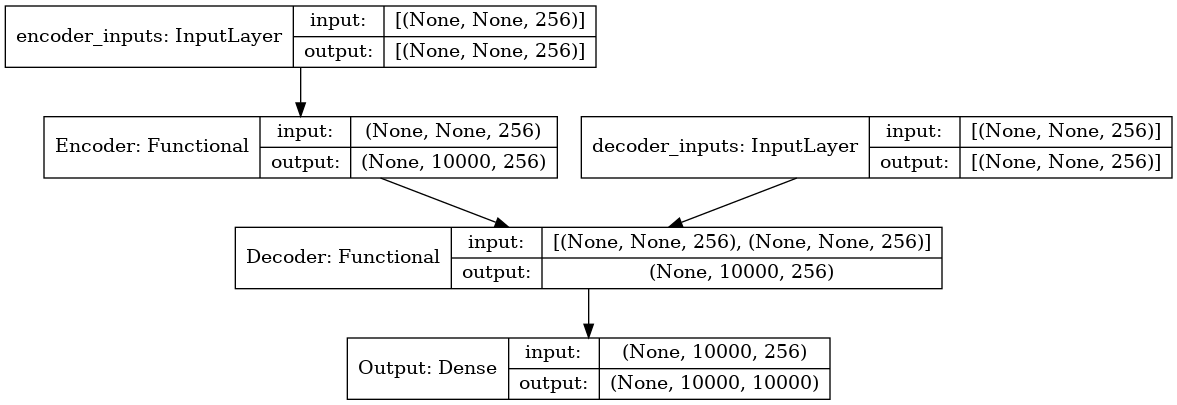

In [43]:
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True)

In [44]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
Encoder (Functional)            (None, 10000, 256)   3162624     encoder_inputs[0][0]             
__________________________________________________________________________________________________
Decoder (Functional)            (None, 10000, 256)   4744704     decoder_inputs[0][0]             
                                                                 Encoder[0][0]          

### **Load Dataset**  

In [26]:
import os

BASE_DIR = "/data/ksb/TestDir"

DATA_BASE_DIR = os.path.join(BASE_DIR, 'sample_articles')
PREPROCESSED_PATH = os.path.join(DATA_BASE_DIR,"Preprocessed-Data")
SUMMARY_PREPROCESSED_PATH = os.path.join(DATA_BASE_DIR,"Summary-Preprocessed-Data")

MODEL_BASE_DIR = os.path.join(BASE_DIR, 'articleSummary-Jupyter')
glove_model_path = os.path.join(MODEL_BASE_DIR, 'glove.model')
corpus_model_path = os.path.join(MODEL_BASE_DIR, 'corpus.model')

임베딩 모델 불러오기

In [27]:
from glove import Corpus, Glove

glove = Glove.load(glove_model_path)
corpus = Corpus.load(corpus_model_path)

전처리 된 기사를 통해 토큰화 및 정수 인코딩 수행  

```
"국회 정기 국회 마지막 날 정국 전운 감돌 있"      # 전처리 된 기사

[32, 342, 273, 280, 129, 222, 34, 55, 3] # 정수 인코딩 수행한 문장

```

In [28]:
import re

class RawTextReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile("/n")

    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in ch:
                yield s

In [44]:
class IntegerEncoder:
    def __init__(self, filepath, corpus):
        self.filepath = filepath
        self.corpus = corpus
    
    def get_encoded_vec_matrix(self):
        media_list = os.listdir(self.filepath)
        
        encoded_vec_list = []
        for media_name in media_list:
    
            media_path = os.path.join(self.filepath, media_name)
            article_list = os.listdir(media_path)
            
            for article_name in article_list:
                
                reader = RawTextReader(os.path.join(media_path, article_name)) 
                content = list(filter(None, reader))
                corpus
                vec = np.array([corpus.dictionary[token] for sent in content for token in sent.split() if token in corpus.dictionary])
                
                encoded_vec_list.append(vec)

        return np.array(encoded_vec_list)

target data는 train data로부터 추출된 문장이므로, target vocabulary와 train vocabulary는 동일하다.  

아래는 PREPROCESSED_PATH 내 텍스트를 이용해 train data 구성하는 내용이다.  


```
Encoder Input Sequence Number : 기사의 개수 (약 100,000개)
Decoder Input Sequence Number : 기사의 요약문 개수 (약 100,000개)

D_MODEL : 임베딩 벡터 차원 (256 차원)

```

In [43]:
train_encoder = IntegerEncoder(PREPROCESSED_PATH, corpus)
train_encoded_matrix = train_encoder.get_encoded_vec_matrix()
train_encoded_matrix.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(99237,)

SUMMARY_PREPROCESSED_PATH 내 텍스트를 이용해 target data 구성

In [ ]:
target_encoder = IntegerEncoder(SUMMARY_PREPROCESSED_PATH, corpus)
target_encoded_matrix = target_encoder.get_encoded_vec_list()

In [ ]:
model.fit(dataset, epochs=EPOCHS)